# _Combinatorial_ (or _collage_) Data Augmentation

In this project I develop and test a data augmentation approach to solve binary image classification problems, when the number of labelled images is very low (e.g., 10 from each class). The approach could be adapted for more than just two categories, but in this notebook I only treat the case $k=2$. I use the Fashion MNIST dataset, which has 10 classes of clothing, and the numeric tests performed use all 45 possible pairs (with no order). Future work could deal with a different dataset and/or $k>2$.

I have not come across the idea described here in any paper, blog post, course, etc. To the best of my knowledge this is a novel technique. However, due to its relative simplicity, and effectiveness (at least on the Fashion-MNIST dataset), it is possible that other people had developed this approach or similar ones before.

#### Problem setup: 

A training set of labelled images $X_t$, with $m_1$ and $m_2$ images in classes $c_1$ and $c_2$, where $m=m_1+m_2$ is small. There is also a validation dataset of labelled images $X_v$, which we will assume to be half the size of $X_t$, so that $X_v$ is 33% of the labelled images. $X_t$ and $X_v$ are drawn or generated with the same distribution. The goal is to obtain a neural network to classify images using these two classes. 

We assume that a pre-trained network, such as a _resnet_, is available. In fact, the approach that we introduce relies on using a rather powerful pre-trained network. 

But for the problem to be of interest, we assume that the two classes $c_1, c_2$ are not classes for which the available pre-trained network has been trained.

#### Benchmark solution:

The benchmark performance is given by a neural network $N_b$, which is obtained by applying a transfer learning process $T_b$ on a given pre-trained neural network $N_0$, using $X_t$ to adjust the weights of $N_0$, and $X_v$ to select the best performing set of weights along the epochs. Here we are going to use resnet34 as $N_0$.

#### Improved solution:

The improved solution relies on _collages_, which are simply rectangular arrays of images from $X_t$.

(1) Create a dataset of $M>>m$ _collages_ from $X_t$, which is denoted $C=C(X_t)$, having to 2 classes. Obtain a neural network $N_{alt}$ by applying a transfer learning process $T_{alt}$, on $N_0$, using the dataset $C$. 

(2) Obtain a neural network $N_{cda}$, by applying a transfer learning process $T_{cda}$, on the neural network $N_{alt}$, using the datasets $X_t,X_v$ (in the same way the benchmark is obtained).

The processes $T_b$ and $T_{cda}$ should be essentially the same, aside from the fact that they are applied to two different pre-trained neural networks, $N_0$ and $N_{alt}$, with the same architecture, but different initial weights. Both transfers are based on the same datasets $X_t,X_v$, use the same data augmentations on $X_t$, and tune the exact same layers of their corresponding starting networks, $N_0$ and $N_{alt}$. The only advantage given to the benchmark is to double the number of epochs, for reasons explained later.

We call this method _combinatorial (or collage) data augmentation_ (CDA).

More precisely:

- Input of the problem: $(N_0, X_t, X_v)$, where $X_t,X_v$ are labelled images in classes $c_0$, $c_1$, and $N_0$ is a pre-trained network _not_ trained on classes $c_0,c_1$. 

- Goal: obtain a network that generalizes better than the benchmark in classifying classes $c_0, c_1$, on a testing dataset, disjoint from $X_t$ and $X_v$ but with the same distribution.

- Benchmark: $N_b$, a network trained on class $c_0,c_1$, obtained via $T_b: (N_0,X_t,X_v) \mapsto N_b$, tuning only the last $l$ layers from $N_0$, during $n_{ep}$ epochs.

- CDA steps:
    - Obtain $C=C(X_t)$, with $M>>m$ images (collages) in classes $c_1', c_2'$.
    - Obtain $N_{alt}$ as a result of $T_{alt}:(N_0,C) \mapsto N_{alt}$, tuning at least the last $l+1$ layers of $N_0$. 
    - Obtain $N_{cda}$ as a result of $T_{cda}:(N_{alt},X_t,X_v) \mapsto N_{cda}$, tuning only the last $l$ layers of $N_0$, during $n_{ep}$ epochs.

#### Collages:
The set $C=C(X_t)$ of collages over $X_t$ is the result of a data augmentation process that goes from the original $m=m_1+m_2$ images up to $m^{(q^2)}$ images, where the integer $q$ is a parameter of the method ($q>1$, since $q=1$ is just the usual transfer learning).

In the experiments shown here we use $q=2,3,4$. The smaller the value of $m$, the larger the value of $q$, so that $C$ is guaranteed to be large enough. In this project we make $C$ of size approximately $50,000$.

For simplicity we assume that the $m$ images in $X_t,X_v$ have all the same size.

Given $q$, a collage is simply an array of $q^2$ images from $X_t$, in a $q \times q$ shape. One could also use rectangular (non-square arrays, but it's the same idea).

##### Labels in $C$
Each collage needs a label $c_1'$ or $c_2'$. There could be different ways to do this, but we simply use the _majority_ vote: the label of a collage is $c_1$ iff at least $q^2/2$ of the $q^2$ images used to build the collage are in class $c_1$.

##### Note:
In this notebook we describe the CDA _binary_ approach, but in principle one can apply the same idea to a multi-class collage dataset $C$. To adapt it to $k>2$, some of the code below needs modifications. 


#### Generating $C$

To generate $C$, we consider each of the $2^{(q^2)}$ possible configurations in which labels $c_1$ and $c_2$ can be located in a $q \times q$ collage. Each configuration has $\binom{q^2}{j}m_1^j m_2^{(q^2-j)}$ distinct possible collages, where $j$ is the number (between $0$ and $q^2$) of images from $c_1$ in the collage. Adding over $j$ from $0$ to $q^2$, we get all the $(m_1+m_2)^{(q^2)}$ possible collages.

Since $(m_1+m_2)^{(q^2)}$ can be easily too large, we may want a subset of the possible collages. In this work we select a subset of $N$ images for each of the $2^{(q^2)}$ configurations. For example, we may generate $N=100$ random collages for each configuration. Collages randomly generated for a given configuration may repeat themselves, but we keep only one copy of each. So the total number of images in $C$ will be bounded by $N \cdot 2^{(q^2)}$. The expected number of distinct collages per configuration is easy to estimate fairly accurately (see below).

# Dataset

The Fashion-MNIST dataset https://github.com/zalandoresearch/fashion-mnist contains images for 10 categories of clothing, with 6,000 training images and 1,000 testing images for each category, giving at total of 70,000 images.

The list of categories is: 

- tshirt (T-shirt/top)
- trouser 
- pullover
- dress
- coat
- sandal
- shirt
- sneaker
- bag
- boot (Ankle boot)

# Experiment

The purpose of this project is to compare throughout a numerical experiment the two techniques described: the benchmark binary classification, obtained on straightforward transfer learning, versus the CDA approach introduced here.

There are some parameters of the experiment that we are going to be varying, and the performance of the two methods is going to be measured over all the values considered for these parameters.

- The classes: $(c_1,c_2)$, which could be any two of the 10 available (giving 45 combinations as sets).

- The value $m=|X_t|$. For simplicity both classes will have the same number of images in $X_t$, so $m_1=m_2=m/2$, and $X_v$ will be half the size of $X_t$. So we introduce a parameter $s$, integer, and make $X_t$ with $2s$ images in each class $c_1,c_2$, and $X_v$ with $s$ images in each class. For example, when $s=2$, then $X_t$ will have 8 images and $X_v$ will have 4 images. 

- The value $q$. We will use 2,3,4.

- Number of epochs used to obtain benchmark and the CDA classifier. The CDA will be obtained using $n_{eps}=100$ epochs, while the benchmark will be given twice the number of epochs, just in case longer training could allow it to find a better solution. Our goal is to see if CDA is better, so giving it a disadvantage would make the results more reliable. The reason we do so many epochs is that for such low training set, the batch size equals the training set, so an epoch equals an update of the weights. 


### Steps of the experiment

1. Fix the values for $c_1, c_2, s, q, n_{ep}$

2. Get all 60,000 training images in folder 'train' (case sensitive), inside their corresponding class folders. Likewise for the 10,000 testing images, but in the folder 'test'.

3. Prepare the images for the binary experiment.

    - Pick $s$ images from $c_1$ and $s$ images from $c_2$, and move them into a new validation folder VALID (in their corresponding class folders).

    - Pick $2s$ images from $c_1$ and $2s$ images from $c_2$, and copy them into a new folder TRAIN (in their corresponding class folders).

    - Copy all 2000 $c_1$ and $c_2$ testing images in folder 'test' to a new folder TEST.

From this point, the binary classification problem will continue using only the images in folders TRAIN, VALID, and TEST.

4. Obtain the benchmark classifier, using $2n_{eps}$ epochs to tune the last $l$ layers based on $X_t$, and save best model learned with respect to error rate on $X_v$ as 'benchmark'. 

5. Obtain the CDA classifier, using $n_{eps}$ epochs in $T_2$, and save the learned model as 'cda'.

    - Obtain $C=C(X_t)$, with $M>>m$ images in classes $c_1', c_2'$, and save the collages in TRAIN_ALT, in their corresponding class folders.

    - Obtain $N_{alt}$ as a result of $T_{alt}:(N_0,C) \mapsto N_{alt}$, on at least the last $l+1$ layers of $N_0$.

    - Obtain $N_{cda}$ as a result of $T_{cda}:(N_{alt},X_t,X_v) \mapsto N_{cda}$, on the last $l$ layers of $N_0$, during $n_{ep}$ epochs. As for the benchmark: tune the last $l$ layers based on $X_t$, and save best model learned with respect to error rate on $X_v$.


6. Compare CDA vs benchmark, based on error rates on TEST 

    - The learning process that produces the benchmark and the CDA classifiers would have saved the best model with respect to the error rate (lowest) on the VALID set. Use these models to classify the TEST set and measure the error rates obtained by both classifiers.

### Parameters considered

(a) In the first experiment we consider all 45 possible pairs of categories from Fashion-MNIST. We sort these 45 pairs randomly and increase the value of $s$ from $s=1$ to $=45$, as we decrease $q=4,3,2$. The goal here is to compare Benchmark VS CDA on all pairs, while varying randomly the size of $X_t$ (with very low values).

(b) In the second experiemtn we fix a pair of classes, fix $q=3$ and range $s$ in: $1,2,4,8,16,32,64,128,256$. We do this 3 times for each value of $s$ because the performanc will depend on the particular images selected for $X_t$, specially for small $s$. And we do this for 2 pairs: an easy one to distinguish, and a very hard one to distinguish.

## Conclusions

This notebook presents a technique to deal with transfer-learning when the set of labelled images is too small to do an effective transfer learning using a pre-trained NN that has not originally being trained on the given labels.

The technique is tested on the Fashion-MNIST dataset, showing very promising results in terms of error rate reduction on a test set.

The reduction on error rate depends on the categories used (here only binary case is studied), as well as the subset of images randomly selected for each run of the experiment.

The experiments show that almost every time the CDA technique has a significantly better performance than the benchmark.

Despite the dramatic reduction in the error rate on test set, it must be acknowledged that behind CDA there is a significant amount of training. For example, with 50,000 collages to obtain $N_{alt}$ and bs=64, the 2 epochs training $N_{alt}$ equates to 2*50000/64=1562 weights updates. Meanwhile, for the benchmark, 1 epoch equates to 1 weight update because the batch size in this case equals $m$, the number of training images. So, while the benchmark has 200 updates behind it, CDA has 100 updates + 1562 updates. It could be argued that to make things even in terms of weights updates, the benchmark should run 1662 epochs instead of 200. First, it is not clear that more epochs would reduce the error as substantially as CDA does (since it seems that within the 200 epochs the error rate on validation is not monotonically decreasing). More importantly, doing that many epochs for the benchmark would be extremely inefficient, so at the very least CDA gives an efficient way to do the weight updates.


In [88]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import * 

import numpy as np
import pandas as pd
import os
import gzip
from PIL import Image, ImageDraw, ImageOps
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from os import listdir, walk
from os.path import isfile, join
%matplotlib inline

In [89]:
path = Path('/home/jupyter/.fastai/data/fashion-mnist')

In [90]:
''' DO ONLY ONCE

%%bash
cd /home/jupyter/.fastai/data/fashion-mnist

mkdir train
mkdir test
mkdir train/tshirt
mkdir test/tshirt
mkdir train/trouser
mkdir test/trouser
mkdir train/pullover
mkdir test/pullover
mkdir train/dress
mkdir test/dress
mkdir train/coat
mkdir test/coat
mkdir train/sandal
mkdir test/sandal
mkdir train/shirt
mkdir test/shirt
mkdir train/sneaker
mkdir test/sneaker
mkdir train/bag
mkdir test/bag
mkdir train/boot
mkdir test/boot
''' 
0


0

## 1. Hyper-parameters


In [91]:
# DICTIONARY OF LABELS
label_dict = {0:'tshirt', 1:'trouser', 2:'pullover', 3:'dress', 4:'coat', 5:'sandal', 6:'shirt', 7:'sneaker', 8:'bag', 9:'boot'}

In [92]:
n_ep = 100

### 1.1 

All 45 possible pairs of categories from Fashion-MNIST, sorted randomly, and using increasing values for $m$ (even) between 2 and 90, while the values of $q$ go as 4, 3, and 2.

In [93]:
'''
J = 0 # from 0 to 44

#pairs = [[x,y] for x in range(10) for y in range(x)]
#np.random.shuffle(pairs)
#print(pairs)

pairs = [[8, 0], [8, 2], [9, 5], [9, 1], [6, 3], [8, 7], [7, 6], [4, 0], [3, 1], [9, 0], [6, 1], [2, 1], [4, 1], [9, 2], [7, 3],
         [4, 3], [3, 0], [6, 0], [8, 3], [9, 6], [8, 4], [8, 5], [6, 4], [7, 0], [7, 5], [9, 3], [7, 1], [7, 4], [5, 1], [2, 0],
         [6, 5], [9, 7], [1, 0], [9, 4], [4, 2], [5, 3], [6, 2], [5, 4], [5, 0], [8, 1], [5, 2], [3, 2], [7, 2], [8, 6], [9, 8]]
Q = 4*[4]+13*[3]+28*[2]
S = np.arange(1,46)

#print(Q)
#print(S)

[c1, c2] = pairs[J]
q = Q[J]
s = S[J]
m = 4*s

# binary labels
label_dict_binary = {'class1': label_dict[c1], 'class2': label_dict[c2]}

print('Classes:', c1, c2)
print(label_dict_binary)
print('s:', s)
print('q:', q)
print('Size of X_t:', m)
'''
0

0

### 1.2

Fix a pair of categories: a very challenging one, and a very easy one. Fix $q=3$ and range $m$ as powers of 2 between 4 and 512, and see the curves of performance for benchmark and CDA. Do this at least 3 times for each pair because the performance (for each $m$) is strongly dependent on the randomly selected subsets of images $X_t,X_v$.

- Hard: shirt, pullover
- Easy: coat, boot

In [94]:
#'''
J = 7

# HARD PAIR
c1, c2 = 2, 6 # pulloever, shirt; OR bag, sandal

# EASY PAIR
#c1, c2 = 4, 9 # coat, boot

q = 3
S = [2**k for k in range(8)]
s = S[J]
m = 4*s

# binary labels
label_dict_binary = {'class1': label_dict[c1], 'class2': label_dict[c2]}

print('Classes:', c1, c2)
print(label_dict_binary)
print('s:', s)
print('q:', q)
print('Size of X_t:', m)
#'''
#0

Classes: 2 6
{'class1': 'pullover', 'class2': 'shirt'}
s: 128
q: 3
Size of X_t: 512


#### All the cells below will give the execution for the run with the specified hyper-parameters

## 2. Save all images

In [95]:
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

##### Remove all images at the beginning of the experiment

In [96]:
%%bash
cd /home/jupyter/.fastai/data/fashion-mnist

rm train/tshirt/*.jpg
rm test/tshirt/*.jpg
rm train/trouser/*.jpg
rm test/trouser/*.jpg
rm train/pullover/*.jpg
rm test/pullover/*.jpg
rm train/dress/*.jpg
rm test/dress/*.jpg
rm train/coat/*.jpg
rm test/coat/*.jpg
rm train/sandal/*.jpg
rm test/sandal/*.jpg
rm train/shirt/*.jpg
rm test/shirt/*.jpg
rm train/sneaker/*.jpg
rm test/sneaker/*.jpg
rm train/bag/*.jpg
rm test/bag/*.jpg
rm train/boot/*.jpg
rm test/boot/*.jpg

##### Create all images

In [97]:
X_train, y_train = load_mnist(path, kind='train')

for k,l in enumerate(y_train):
    img = Image.fromarray(np.array(np.reshape(X_train[k],(28,28))))
    file_nm = (5-len(str(k)))*'0'+str(k)+'.jpg'
    img.save(path/('train/'+label_dict[l]+'/'+file_nm))

In [98]:
X_test, y_test = load_mnist(path, kind='t10k')

for k,l in enumerate(y_test):
    img = Image.fromarray(np.array(np.reshape(X_test[k],(28,28))))
    file_nm = (5-len(str(k)))*'0'+str(k)+'.jpg'
    img.save(path/('test/'+label_dict[l]+'/'+file_nm))

## 3. Prepare images for the binary case

In [99]:
print(label_dict_binary)
print('Size of each class in X_t:', 2*s)
print('Size of each class in X_v:', s)

{'class1': 'pullover', 'class2': 'shirt'}
Size of each class in X_t: 256
Size of each class in X_v: 128


#####  MUST MANUALLY COPY THESE BELOW ! 

### This cell below prepares from scratch the images for the binary case

In [100]:
%%bash

class1="pullover"
class2="shirt"
class_size_t=248
class_size_v=128

cd /home/jupyter/.fastai/data/fashion-mnist

# remove folders that could have been created before
rm -r TRAIN
rm -r VALID
rm -r TEST

mkdir TRAIN
mkdir VALID
mkdir TEST

cd TRAIN
mkdir $class1
mkdir $class2
cd ..
cd VALID
mkdir $class1
mkdir $class2
cd ..


# Move m random images from train to VALID

ls train/$class1 |sort -R |tail -$class_size_v |while read file; do
    mv train/$class1/$file VALID/$class1
done

ls train/$class2 |sort -R |tail -$class_size_v |while read file; do
    mv train/$class2/$file VALID/$class2
done

# Copy m random images from train to TRAIN

ls train/$class1 |sort -R |tail -$class_size_t |while read file; do
    cp train/$class1/$file TRAIN/$class1
done

ls train/$class2 |sort -R |tail -$class_size_t |while read file; do
    cp train/$class2/$file TRAIN/$class2
done

# Copy images from test set
cp -r test/$class1 TEST/
cp -r test/$class2 TEST/


In [101]:
data = (ImageItemList.from_folder(path)
        .split_by_folder(train='TRAIN', valid='VALID')
        .label_from_folder()
        .transform(get_transforms(), size=28)
        .databunch(bs=min(int(m),64)).normalize(imagenet_stats))

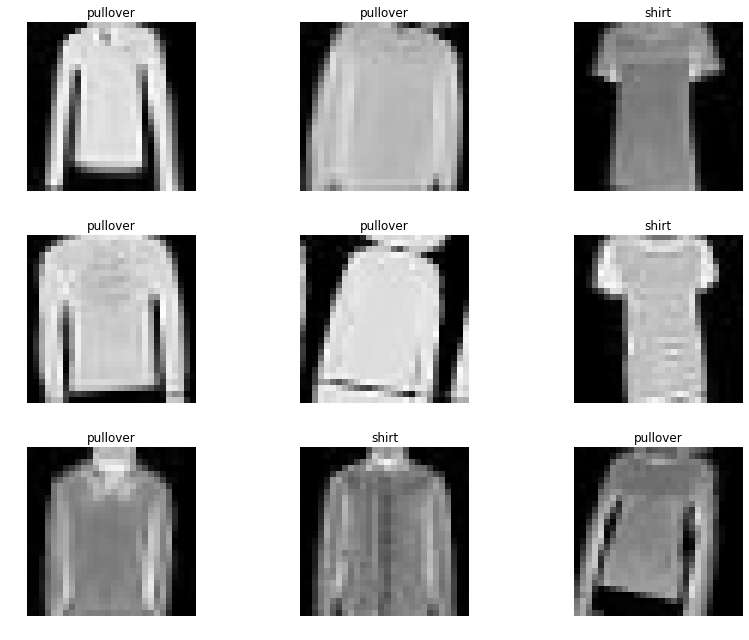

In [102]:
data.show_batch(rows=3, figsize=(12,9))

## 4. Benchmark

In [103]:
learn = create_cnn(data, models.resnet34, metrics=[error_rate])

In [104]:
#learn.fit_one_cycle(n_ep)
learn.fit_one_cycle(2*n_ep,callbacks=[SaveModelCallback(learn,monitor='error_rate', mode='min')])

epoch,train_loss,valid_loss,error_rate
1,0.999749,0.703056,0.464844
2,0.937791,0.695226,0.453125
3,0.906039,0.681114,0.460938
4,0.883127,0.638029,0.367188
5,0.868775,0.624103,0.339844
6,0.846261,0.598710,0.289062
7,0.834354,0.588014,0.304688
8,0.815606,0.581931,0.265625
9,0.788457,0.572134,0.281250
10,0.777148,0.576274,0.285156


In [105]:
learn.save('project_4_benchmark')

## 5. Get CDA classifier

### 5.1 Obtain $C=C(X_t)$, with $M>>m$ images in classes $c_1', c_2'$.

Prepare folders to create $C$

In [106]:
%%bash

cd /home/jupyter/.fastai/data/fashion-mnist

rm -r TRAIN_ALT
mkdir TRAIN_ALT
cd TRAIN_ALT
mkdir class_1
mkdir class_2
cd ..

In [107]:
def collage_from_paths(subpaths, q, thumbnail_width=28, thumbnail_height=28):
    ''' Given a list of paths to q^2 images, this function returns a collage with the images'''
    size = thumbnail_width, thumbnail_height
    new_im = Image.new('RGB', (q*thumbnail_width, q*thumbnail_height))
    ims = []
    for subpath in subpaths:
        im = Image.open(path/subpath)
        im.thumbnail(size)
        ims.append(im)
    i = 0
    x = 0
    y = 0
    for cols in range(q):
        for row in range(q):
            new_im.paste(ims[i], (x, y))
            i += 1
            y += thumbnail_height
        x += thumbnail_width
        y = 0
    return new_im

In [108]:
def collage_from_class(class_nm, q):
    paths = []
    collage_nm = '.jpg'
    for x in class_nm[-q*q:]:
        folder_nm = label_dict_binary['class'+x]
        onlyfiles = [f for f in listdir(path/('TRAIN/'+folder_nm)) if isfile(join(path/('TRAIN/'+folder_nm), f))]
        file_nm = np.random.choice(onlyfiles)
        collage_nm = file_nm[:-4]+collage_nm
        paths.extend(['TRAIN/'+folder_nm+'/'+file_nm])
    new_collage = collage_from_paths(paths, q)
    if class_nm[-q*q:].count('1')>(q*q/2):
        new_collage.save(path/('TRAIN_ALT/class_1/'+collage_nm))
    else:
        new_collage.save(path/('TRAIN_ALT/class_2/'+collage_nm))

In [109]:
itertools.product
classes = ["".join(seq) for seq in itertools.product("12", repeat=q*q)]
len(classes)

512

In [110]:
N = max(int((50000/len(classes)/10))*10,1) # this guarantees the that total number of collages is around 50,000
N

90

In [111]:
for class_nm in classes:
    for j in range(N):
        collage_from_class(class_nm, q)

In [112]:
CDA_class_1_n = len([f for f in listdir(path/('TRAIN_ALT/class_1')) if isfile(join(path/('TRAIN_ALT/class_1'), f))])
CDA_class_2_n = len([f for f in listdir(path/('TRAIN_ALT/class_2')) if isfile(join(path/('TRAIN_ALT/class_2'), f))])
print('CDA Training examples class 1:', CDA_class_1_n)
print('CDA Training examples class 2:', CDA_class_2_n)
print('CDA Training examples: ', CDA_class_1_n+CDA_class_2_n)
k=2
y = m**(q*q)
print('Expected number of distinct collages (Train and Valid):', (k**(q*q))*y*(1-((y-1)/y)**N))

CDA Training examples class 1: 23040
CDA Training examples class 2: 23040
CDA Training examples:  46080
Expected number of distinct collages (Train and Valid): 0.0


In [113]:
data = (ImageItemList.from_folder(path/'TRAIN_ALT')
        .random_split_by_pct(0.2)
        .label_from_folder()
        .transform(get_transforms(), size=28*q)
        .databunch().normalize(imagenet_stats))

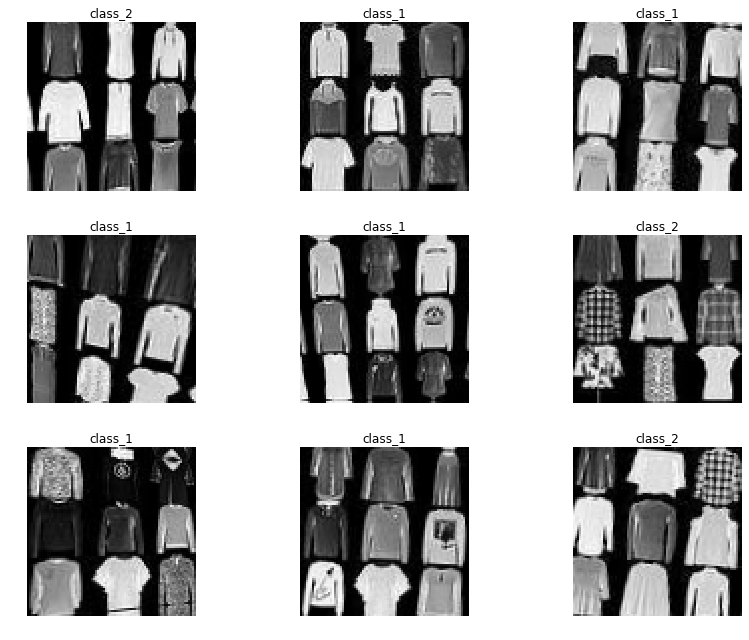

In [114]:
data.show_batch(rows=3, figsize=(12,9))

### 5.2 Obtain $N_{alt}$ as a result of $T_{alt}:(N_0,C) \mapsto N_{alt}$, on at least the last $l+1$ layers of $N_0$.

#### Depending on how many images are in TRAIN_ALT, this seems to determine the layers being calibrated, regardless of the freeze_to parameter (when the number of images is large. This becomes evident because even when one does freeze_to(-1), with a large amount of images, the error rate goes very low, which could not happen if the last layer is the only one being tuned.

In [283]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [284]:
learn.freeze_to(-10)
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate
1,0.084670,0.031987,0.012044
2,0.020865,0.000600,0.000000


In [285]:
learn.save('project_4_alt')

### 5.3 Obtain $N_{cda}$ as a result of $T_{cda}:(N_{alt},X_t,X_v) \mapsto N_{cda}$, on the last $l$ layers of $N_0$, during $n_{ep}$ epochs.

In [286]:
data = (ImageItemList.from_folder(path)
        .split_by_folder(train='TRAIN', valid='VALID')
        .label_from_folder()
        .transform(get_transforms(), size=28)
        .databunch(bs=min(int(m),64)).normalize(imagenet_stats))

In [287]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [288]:
learn.load(path/'TRAIN_ALT/models/project_4_alt')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (496 items)
[Category boot, Category boot, Category boot, Category boot, Category boot]...
Path: /home/jupyter/.fastai/data/fashion-mnist
x: ImageItemList (496 items)
[Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28)]...
Path: /home/jupyter/.fastai/data/fashion-mnist;

Valid: LabelList
y: CategoryList (256 items)
[Category boot, Category boot, Category boot, Category boot, Category boot]...
Path: /home/jupyter/.fastai/data/fashion-mnist
x: ImageItemList (256 items)
[Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28)]...
Path: /home/jupyter/.fastai/data/fashion-mnist;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_s

In [289]:
#learn.fit_one_cycle(n_ep)
learn.fit_one_cycle(n_ep,callbacks=[SaveModelCallback(learn,monitor="error_rate",mode='min')])

epoch,train_loss,valid_loss,error_rate
1,10.728062,5.561066,1.000000
2,10.436913,4.952229,1.000000
3,10.174079,4.851856,1.000000
4,9.797670,5.071229,1.000000
5,9.339849,5.217250,1.000000
6,8.813060,4.772799,1.000000
7,8.158193,3.591669,1.000000
8,7.313778,1.989663,0.792969
9,6.320671,0.524781,0.414062
10,5.311886,0.063629,0.000000


In [290]:
learn.save('project_4_cda')

## 6. Compare CDA vs benchmark, based on error rates TEST 

In [291]:
def getTestPerformance(model_nm):
    data = (ImageItemList.from_folder(path)
            .split_by_folder(train='TRAIN', valid='TEST')
            .label_from_folder()
            .transform(get_transforms(), size=28)
            .databunch(bs=min(int(m),64)).normalize(imagenet_stats))
    learn = create_cnn(data, models.resnet34, metrics=error_rate)
    learn.load(path/('models/'+model_nm))
    predictions, actuals = learn.get_preds(ds_type=DatasetType.Valid)
    predictions = 1*(np.transpose(np.array(predictions))[1]>0.5)
    actuals = np.array(actuals)
    return 1-accuracy_score(predictions, actuals)

In [292]:
error_test_bench = getTestPerformance('project_4_benchmark')

In [293]:
error_test_cda = getTestPerformance('project_4_cda')

In [294]:
X_t_1_n = len([f for f in listdir(path/('TRAIN/'+label_dict_binary['class1'])) if isfile(join(path/('TRAIN/'+label_dict_binary['class1']), f))])
X_t_2_n = len([f for f in listdir(path/('TRAIN/'+label_dict_binary['class2'])) if isfile(join(path/('TRAIN/'+label_dict_binary['class2']), f))])
X_v_1_n = len([f for f in listdir(path/('VALID/'+label_dict_binary['class1'])) if isfile(join(path/('VALID/'+label_dict_binary['class1']), f))])
X_v_2_n = len([f for f in listdir(path/('VALID/'+label_dict_binary['class2'])) if isfile(join(path/('VALID/'+label_dict_binary['class2']), f))])

results_J = [c1, c2, label_dict_binary['class1'], label_dict_binary['class2'], 
             s, m, X_t_1_n, X_t_2_n, X_v_1_n, X_v_2_n, 
             q, N, CDA_class_1_n, CDA_class_2_n,
             error_test_bench, error_test_cda, error_test_bench/error_test_cda]

In [295]:
print(results_J)

[4, 9, 'coat', 'boot', 128, 512, 248, 248, 128, 128, 3, 90, 23040, 23040, 0.010000000000000009, 0.0010000000000000009, 10.0]


### Results for an easy pair

In [53]:
results = [[4, 9, 'coat', 'boot', 1, 4, 2, 3, 90, 21119, 21061, 0.44299999999999995, 0.2975, 1.4890756302521007],
           [4, 9, 'coat', 'boot', 1, 4, 2, 3, 90, 21186, 21230, 0.4355, 0.14, 3.1107142857142853],
           [4, 9, 'coat', 'boot', 1, 4, 2, 3, 90, 21116, 21227, 0.31699999999999995, 0.129, 2.457364341085271],
           [4, 9, 'coat', 'boot', 2, 8, 4, 3, 90, 23033, 23037, 0.14600000000002, 0.00249999999467, 58.400000000],
           [4, 9, 'coat', 'boot', 2, 8, 4, 3, 90, 23037, 23033, 0.1069999998, 0.07850000001, 1.3630573248407638],
           [4, 9, 'coat', 'boot', 2, 8, 4, 3, 90, 23034, 23030, 0.108500000004, 0.025000000022, 4.3399999998],
           [4, 9, 'coat', 'boot', 4, 16, 8, 3, 90, 23040, 23040, 0.086999999997, 0.0060000000, 14.499999999982],
           [4, 9, 'coat', 'boot', 4, 16, 8, 3, 90, 23040, 23040, 0.118, 0.0044999999999999485, 26.22222222222252],
           [4, 9, 'coat', 'boot', 4, 16, 8, 3, 90, 23040, 23040, 0.1925, 0.050000000000000044, 3.8499999999999965],
           [4, 9, 'coat', 'boot', 8, 32, 16, 3, 90, 23040, 23040, 0.1215000000, 0.00700000000, 17.35714285714285],
           [4, 9, 'coat', 'boot', 8, 32, 16, 3, 90, 23040, 23040, 0.08350000000, 0.01849999999, 4.5135135135],
           [4, 9, 'coat', 'boot', 8, 32, 16, 3, 90, 23040, 23040, 0.13, 0.10150000000000003, 1.280788177339901],
           [4, 9, 'coat', 'boot', 16, 64, 32, 3, 90, 23040, 23040, 0.022000000002, 0.0270000000024, 0.81481481],
           [4, 9, 'coat', 'boot', 16, 64, 32, 3, 90, 23040, 23040, 0.01500000000000, 0.0044999999994, 3.333333333],
           [4, 9, 'coat', 'boot', 16, 64, 32, 3, 90, 23040, 23040, 0.04249999999, 0.00149999999, 28.3333333333],
           [4, 9, 'coat', 'boot', 32, 128, 64, 3, 90, 23040, 23040, 0.029000000000000026, 0.0, np.Inf],
           [4, 9, 'coat', 'boot', 32, 128, 64, 3, 90, 23040, 23040, 0.0615, 0.0004999999999, 123.00000000001354],
           [4, 9, 'coat', 'boot', 32, 128, 64, 3, 90, 23040, 23040, 0.03500000000, 0.001000000000, 35.0],
           [4, 9, 'coat', 'boot', 64, 256, 128, 3, 90, 23040, 23040, 0.006499999995, 0.00400000000036, 1.6249999999],
           [4, 9, 'coat', 'boot', 64, 256, 128, 3, 90, 23040, 23040, 0.00649999999999995, 0.0, np.Inf],
           [4, 9, 'coat', 'boot', 64, 256, 128, 3, 90, 23040, 23040, 0.012000000, 0.000499999949, 24.00000002665],
           [4, 9, 'coat', 'boot', 128, 512, 256, 3, 90, 23040, 23040, 0.01849999999999996, 0.0, np.Inf],
           [4, 9, 'coat', 'boot', 128, 512, 256, 3, 90, 23040, 23040, 0.009499999953, 0.00049999999449, 19.000000],
           [4, 9, 'coat', 'boot', 128, 512, 256, 3, 90, 23040, 23040, 0.010000000, 0.00100000000, 10.0]
          ]
    
cols = ['class_1', 'class_2', 'class_1_nm', 'class_2_nm', 
        's', '|X_t|', '|X_v|', 
        'q', 'N', 'CDA_cl_1_n', 'CDA_cl_2_n',
        'test_error_bnch', 'test_error_cda', 'bnch_to_CDA_error_ratio',
        ]

pd_results = pd.DataFrame(results, columns = cols)
pd_results    

,class_1,class_2,class_1_nm,class_2_nm,s,|X_t|,|X_v|,q,N,CDA_cl_1_n,CDA_cl_2_n,test_error_bnch,test_error_cda,bnch_to_CDA_error_ratio
0,4,9,coat,boot,1,4,2,3,90,21119,21061,0.4430,0.2975,1.489076
1,4,9,coat,boot,1,4,2,3,90,21186,21230,0.4355,0.1400,3.110714
2,4,9,coat,boot,1,4,2,3,90,21116,21227,0.3170,0.1290,2.457364
3,4,9,coat,boot,2,8,4,3,90,23033,23037,0.1460,0.0025,58.400000
4,4,9,coat,boot,2,8,4,3,90,23037,23033,0.1070,0.0785,1.363057
5,4,9,coat,boot,2,8,4,3,90,23034,23030,0.1085,0.0250,4.340000
6,4,9,coat,boot,4,16,8,3,90,23040,23040,0.0870,0.0060,14.500000
7,4,9,coat,boot,4,16,8,3,90,23040,23040,0.1180,0.0045,26.222222
8,4,9,coat,boot,4,16,8,3,90,23040,23040,0.1925,0.0500,3.850000
9,4,9,coat,boot,8,32,16,3,90,23040,23040,0.1215,0.0070,17.357143


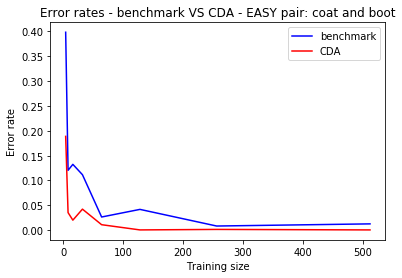

In [54]:
pd_groupby = pd_results.groupby('s').mean()
plt.plot(pd_groupby['|X_t|'].values, pd_groupby['test_error_bnch'].values, 'b', label='benchmark')
plt.plot(pd_groupby['|X_t|'].values, pd_groupby['test_error_cda'].values, 'r', label='CDA')
plt.xlabel('Training size')
plt.ylabel('Error rate')
plt.legend()
plt.title('Error rates - benchmark VS CDA - EASY pair: coat and boot')
plt.show()

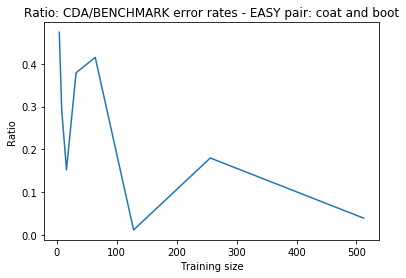

In [55]:
pd_groupby = pd_results.groupby('s').mean()
plt.plot(pd_groupby['|X_t|'].values, pd_groupby['test_error_cda'].values/pd_groupby['test_error_bnch'].values)
plt.xlabel('Training size')
plt.ylabel('Ratio')
plt.title('Ratio: CDA/BENCHMARK error rates - EASY pair: coat and boot')
plt.show()

### Results for a difficult pair

In [56]:
results = [[2, 6, 'pullover', 'shirt', 1, 4, 2, 3, 90, 21120, 21193, 0.512, 0.3085, 1.6596434359805512],
           [2, 6, 'pullover', 'shirt', 1, 4, 2, 3, 90, 21124, 21131, 0.5465, 0.44999999999999996, 1.2144444444444444],
           [2, 6, 'pullover', 'shirt', 1, 4, 2, 3, 90, 21106, 21177, 0.5865, 0.45499999999999996, 1.289010989010989],
           [2, 6, 'pullover', 'shirt', 2, 8, 4, 3, 90, 23039, 23040, 0.42700000000000005, 0.348, 1.2270114942528738],
           [2, 6, 'pullover', 'shirt', 2, 8, 4, 3, 90, 23038, 23034, 0.43899999999999995, 0.37, 1.1864864864864864],
           [2, 6, 'pullover', 'shirt', 2, 8, 4, 3, 90, 23039, 23037, 0.5605, 0.369, 1.518970189701897],
           [2, 6, 'pullover', 'shirt', 4, 16, 8, 3, 90, 23040, 23040, 0.41700000004, 0.2694999996, 1.547309833024119],
           [2, 6, 'pullover', 'shirt', 4, 16, 8, 3, 90, 23040, 23040, 0.376, 0.2915, 1.2898799313893654],
           [2, 6, 'pullover', 'shirt', 4, 16, 8, 3, 90, 23040, 23040, 0.365, 0.3435, 1.0625909752547307],
           [2, 6, 'pullover', 'shirt', 8, 32, 16, 3, 90, 23040, 23040, 0.4115, 0.274, 1.501824817518248],
           [2, 6, 'pullover', 'shirt', 8, 32, 16, 3, 90, 23040, 23040, 0.355, 0.3185, 1.1145996860282574],
           [2, 6, 'pullover', 'shirt', 8, 32, 16, 3, 90, 23040, 23040, 0.3125, 0.2285000000004, 1.3676148796498904],
           [2, 6, 'pullover', 'shirt', 16, 64, 32, 3, 90, 23040, 23040, 0.32099999995, 0.1885, 1.7029177718832889],
           [2, 6, 'pullover', 'shirt', 16, 64, 32, 3, 90, 23040, 23040, 0.273, 0.1700000000004, 1.6058823529411763],
           [2, 6, 'pullover', 'shirt', 16, 64, 32, 3, 90, 23040, 23040, 0.3125, 0.235, 1.3297872340425532],
           [2, 6, 'pullover', 'shirt', 32, 128, 64, 3, 90, 23040, 23040, 0.3115, 0.1775, 1.7549295774647888],
           [2, 6, 'pullover', 'shirt', 32, 128, 64, 3, 90, 23040, 23040, 0.2295000004, 0.1564999997, 1.46645367412],
           [2, 6, 'pullover', 'shirt', 32, 128, 64, 3, 90, 23040, 23040, 0.2975, 0.1835, 1.6212534059945505],
           [2, 6, 'pullover', 'shirt', 64, 256, 128, 3, 90, 23040, 23040, 0.2524999995, 0.15949999998, 1.5830721003],
           [2, 6, 'pullover', 'shirt', 64, 256, 128, 3, 90, 23040, 23040, 0.199999996, 0.171499999, 1.16618075801],
           [2, 6, 'pullover', 'shirt', 64, 256, 128, 3, 90, 23040, 23040, 0.211500000, 0.143000000, 1.47902097902],
           [2, 6, 'pullover', 'shirt', 128, 512, 256, 3, 90, 23040, 23040, 0.223500000, 0.127, 1.7598425196],
           [2, 6, 'pullover', 'shirt', 128, 512, 256, 3, 90, 23040, 23040, 0.1845, 0.122500000, 1.506122448],
           [2, 6, 'pullover', 'shirt', 128, 512, 256, 3, 90, 23040, 23040, 0.2019999, 0.1374999999, 1.469090909]
          ]
    
cols = ['class_1', 'class_2', 'class_1_nm', 'class_2_nm', 
        's', '|X_t|', '|X_v|', 
        'q', 'N', 'CDA_cl_1_n', 'CDA_cl_2_n',
        'test_error_bnch', 'test_error_cda', 'bnch_to_CDA_error_ratio',
        ]

pd_results = pd.DataFrame(results, columns = cols)
pd_results    

,class_1,class_2,class_1_nm,class_2_nm,s,|X_t|,|X_v|,q,N,CDA_cl_1_n,CDA_cl_2_n,test_error_bnch,test_error_cda,bnch_to_CDA_error_ratio
0,2,6,pullover,shirt,1,4,2,3,90,21120,21193,0.5120,0.3085,1.659643
1,2,6,pullover,shirt,1,4,2,3,90,21124,21131,0.5465,0.4500,1.214444
2,2,6,pullover,shirt,1,4,2,3,90,21106,21177,0.5865,0.4550,1.289011
3,2,6,pullover,shirt,2,8,4,3,90,23039,23040,0.4270,0.3480,1.227011
4,2,6,pullover,shirt,2,8,4,3,90,23038,23034,0.4390,0.3700,1.186486
5,2,6,pullover,shirt,2,8,4,3,90,23039,23037,0.5605,0.3690,1.518970
6,2,6,pullover,shirt,4,16,8,3,90,23040,23040,0.4170,0.2695,1.547310
7,2,6,pullover,shirt,4,16,8,3,90,23040,23040,0.3760,0.2915,1.289880
8,2,6,pullover,shirt,4,16,8,3,90,23040,23040,0.3650,0.3435,1.062591
9,2,6,pullover,shirt,8,32,16,3,90,23040,23040,0.4115,0.2740,1.501825


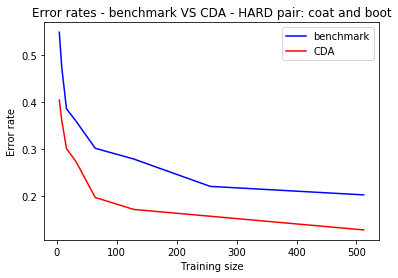

In [57]:
pd_groupby = pd_results.groupby('s').mean()
plt.plot(pd_groupby['|X_t|'].values, pd_groupby['test_error_bnch'].values, 'b', label='benchmark')
plt.plot(pd_groupby['|X_t|'].values, pd_groupby['test_error_cda'].values, 'r', label='CDA')
plt.xlabel('Training size')
plt.ylabel('Error rate')
plt.legend()
plt.title('Error rates - benchmark VS CDA - HARD pair: pullover and shirt')
plt.show()

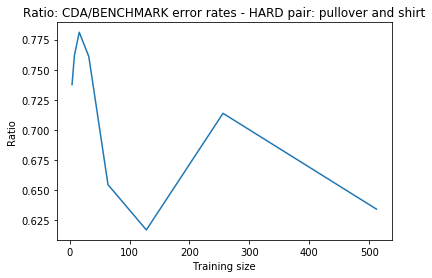

In [59]:
pd_groupby = pd_results.groupby('s').mean()
plt.plot(pd_groupby['|X_t|'].values, pd_groupby['test_error_cda'].values/pd_groupby['test_error_bnch'].values)
plt.xlabel('Training size')
plt.ylabel('Ratio')
plt.title('Ratio: CDA/BENCHMARK error rates - HARD pair: pullover and shirt')
plt.show()

### Results for all pairs

In [61]:
results = [
[8, 0, 'bag', 'tshirt', 1, 4, 2, 4, 1, 26333, 39203, 0.495, 0.254, 1.9488188976377951],
[8, 2, 'bag', 'pullover', 2, 8, 4, 4, 1, 26333, 39203, 0.38149999999999995, 0.06799999999999995, 5.610294117647062],
[9, 5, 'boot', 'sandal', 3, 12, 6, 4, 1, 26333, 39203, 0.10699999999999998, 0.031000000000000028, 3.451612903225803],
[9, 1, 'boot', 'trouser', 4, 16, 8, 4, 1, 26333, 39203, 0.14400000000000002, 0.008000000000000007, 17.999999999999986],
[6, 3, 'shirt', 'dress', 5, 20, 10, 3, 90, 23040, 23040, 0.23450000000000004, 0.2025, 1.1580246913580248],
[8, 7, 'bag', 'sneaker', 6, 24, 12, 3, 90, 23040, 23040, 0.119, 0.009000000000000008, 13.22222222222221],
[7, 6, 'sneaker', 'shirt', 7, 28, 14, 3, 90, 23040, 23040, 0.05249999999999999, 0.03049999999999997, 1.7213114754098373],
[4, 0, 'coat', 'tshirt', 8, 32, 16, 3, 90, 23040, 23040, 0.17700000000000005, 0.058499999999996, 3.0256410256410264],
[3, 1, 'dress', 'trouser', 9, 36, 18, 3, 90, 23040, 23040, 0.1965, 0.03400000000000003, 5.779411764705878],
[9, 0, 'boot', 'tshirt', 10, 40, 20, 3, 90, 23040, 23040, 0.23150000000000004, 0.012499999999999956, 18.52000000007],
[6, 1, 'shirt', 'trouser', 11, 44, 22, 3, 90, 23040, 23040, 0.0645, 0.034499999999999975, 1.8695652173913058],
[2, 1, 'pullover', 'trouser', 12, 48, 12, 3, 90, 23040, 23040, 0.056499999995, 0.017000000015, 3.3235294117647025],
[4, 1, 'coat', 'trouser', 13, 52, 26, 3, 90, 23040, 23040, 0.08350000000002, 0.0420000000004, 1.9880952380952368],
[9, 2, 'boot', 'pullover', 14, 56, 28, 3, 90, 23040, 23040, 0.0905000000002, 0.00100000000009, 90.499999994],
[7, 3, 'sneaker', 'dress', 15, 60, 30, 3, 90, 23040, 23040, 0.034000000003, 0.018499999996, 1.8378378378378433],
[4, 3, 'coat', 'dress', 16, 64, 32, 3, 90, 23040, 23040, 0.14600000000000002, 0.0989999999998, 1.4747474747474754],
[3, 0, 'dress', 'tshirt', 17, 68, 34, 3, 90, 23040, 23040, 0.30500000000005, 0.09450000000003, 3.227513227513227],
[6, 0, 'shirt', 'tshirt', 18, 72, 36, 2, 3120, 15584, 34284, 0.29800000000000004, 0.261, 1.1417624521072798],
[8, 3, 'bag', 'dress', 19, 76, 38, 2, 3120, 15583, 34306, 0.1374999999996, 0.032499999997, 4.230769230769233],
[9, 6, 'boot', 'shirt', 20, 80, 40, 2, 3120, 15593, 34298, 0.07399999999995, 0.04149999999998, 1.7831325301204817],
[8, 4, 'bag', 'coat', 21, 84, 42, 2, 3120, 15594, 34304, 0.0809999999996, 0.01249999999956, 6.48000000002],
[8, 5, 'bag', 'sandal', 22, 88, 44, 2, 3120, 15597, 34304, 0.038000000034, 0.0729999999995, 0.5205479452054802],
[6, 4, 'shirt', 'coat', 23, 92, 46, 2, 3120, 15598, 34309, 0.34099999999999997, 0.243, 1.4032921810699588],
[7, 0, 'sneaker', 'tshirt', 24, 96, 48, 2, 3120, 15595, 34310, 0.03449999975, 0.0340000003, 1.0147058823529396],
[7, 5, 'sneaker', 'sandal', 25, 100, 50, 2, 3120, 15596, 34313, 0.1845, 0.05449999999999999, 3.3853211009174315],
[9, 3, 'boot', 'dress', 26, 104, 52, 2, 3120, 15598, 34314, 0.0354999999976, 0.0024999999467, 14.200000000000292],
[7, 1, 'sneaker', 'trouser', 27, 108, 54, 2, 3120, 15600, 34313, 0.038000000034, 0.0054999999949, 6.9090909090909784],
[7, 4, 'sneaker', 'coat', 28, 112, 56, 2, 3120, 15595, 34313, 0.039499999999998, 0.000499999999449, 79.0000000865],
[5, 1, 'sandal', 'trouser', 29, 116, 58, 2, 3120, 15596, 34311, 0.01949999999962, 0.002499999999467, 7.80000000151],
[2, 0, 'pullover', 'tshirt', 30, 120, 60, 2, 3120, 15599, 34319, 0.1304999999995, 0.05700000005, 2.2894736842105234],
[6, 5, 'shirt', 'sandal', 31, 124, 62, 2, 3120, 15598, 34318, 0.027000000024, 0.0154999999958, 1.741935483870974],
[9, 7, 'boot', 'sneaker', 32, 128, 64, 2, 3120, 15599, 34314, 0.115999999999, 0.06599999995, 1.757575757575759],
[1, 0, 'trouser', 'tshirt', 33, 132, 66, 2, 3120, 15597, 34317, 0.053499999, 0.019499999962, 2.7435897435897485],
[9, 4, 'boot', 'coat', 34, 136, 68, 2, 3120, 15599, 34315, 0.01700000000015, 0.0004999999449, 34.0000000377],
[4, 2, 'coat', 'pullover', 35, 140, 70, 2, 3120, 15599, 34319, 0.29500000000000004, 0.2825, 1.0442477876106198],
[5, 3, 'sandal', 'dress', 36, 144, 72, 2, 3120, 15599, 34319, 0.061000000000054, 0.01500000000013, 4.0666666666],
[6, 2, 'shirt', 'pullover', 37, 148, 74, 2, 3120, 15600, 34316, 0.2664999999996, 0.152499999997, 1.7475409836065574],
[5, 4, 'sandal', 'coat', 38, 152, 76, 2, 3120, 15600, 34319, 0.02800000000025, 0.0004999999999449, 56.000000000622],
[5, 0, 'sandal', 'tshirt', 39, 156, 78, 2, 3120, 15599, 34319, 0.02849999999997, 0.00149999999458, 19.0000000668],
[8, 1, 'bag', 'trouser', 40, 160, 80, 2, 3120, 15600, 34320, 0.0434999998, 0.007499999951, 5.800000000035],
[5, 2, 'sandal', 'pullover', 41, 164, 82, 2, 3120, 15599, 34320, 0.035000000003, 0.0010000000009, 35.0],
[3, 2, 'dress', 'pullover', 42, 168, 84, 2, 3120, 15600, 34318, 0.0959999997, 0.03300000003, 2.9090909090909056],
[7, 2, 'sneaker', 'pullover', 43, 172, 86, 2, 3120, 15600, 34318, 0.018499999996, 0.0024999999467, 7.400000001425],
[8, 6, 'bag', 'shirt', 44, 176, 88, 2, 3120, 15600, 34320, 0.0865000000002, 0.0230000000002, 3.760869565217389],
[9, 8, 'boot', 'bag', 45, 180, 90, 2, 3120, 15600, 34320, 0.023499999999999965, 0.0, np.Inf]
]

cols = ['class_1', 'class_2', 'class_1_nm', 'class_2_nm', 
        's', '|X_t|', '|X_v|', 
        'q', 'N', 'CDA_cl_1_n', 'CDA_cl_2_n',
        'test_error_bnch', 'test_error_cda', 'bnch_to_CDA_error_ratio',
        ]

pd_results = pd.DataFrame(results, columns = cols)
pd_results

,class_1,class_2,class_1_nm,class_2_nm,s,|X_t|,|X_v|,q,N,CDA_cl_1_n,CDA_cl_2_n,test_error_bnch,test_error_cda,bnch_to_CDA_error_ratio
0,8,0,bag,tshirt,1,4,2,4,1,26333,39203,0.4950,0.2540,1.948819
1,8,2,bag,pullover,2,8,4,4,1,26333,39203,0.3815,0.0680,5.610294
2,9,5,boot,sandal,3,12,6,4,1,26333,39203,0.1070,0.0310,3.451613
3,9,1,boot,trouser,4,16,8,4,1,26333,39203,0.1440,0.0080,18.000000
4,6,3,shirt,dress,5,20,10,3,90,23040,23040,0.2345,0.2025,1.158025
5,8,7,bag,sneaker,6,24,12,3,90,23040,23040,0.1190,0.0090,13.222222
6,7,6,sneaker,shirt,7,28,14,3,90,23040,23040,0.0525,0.0305,1.721311
7,4,0,coat,tshirt,8,32,16,3,90,23040,23040,0.1770,0.0585,3.025641
8,3,1,dress,trouser,9,36,18,3,90,23040,23040,0.1965,0.0340,5.779412
9,9,0,boot,tshirt,10,40,20,3,90,23040,23040,0.2315,0.0125,18.520000


In [87]:
pd_results['ratio_CDA_over_BENCHMARK_errors'] = pd_results.test_error_cda/pd_results.test_error_bnch
pd_results[['class_1_nm', 'class_2_nm', '|X_t|', 'test_error_bnch', 'test_error_cda', 'ratio_CDA_over_BENCHMARK_errors']].sort_values(by='ratio_CDA_over_BENCHMARK_errors')

,class_1_nm,class_2_nm,|X_t|,test_error_bnch,test_error_cda,ratio_CDA_over_BENCHMARK_errors
44,boot,bag,180,0.0235,0.0000,0.000000
13,boot,pullover,56,0.0905,0.0010,0.011050
27,sneaker,coat,112,0.0395,0.0005,0.012658
37,sandal,coat,152,0.0280,0.0005,0.017857
40,sandal,pullover,164,0.0350,0.0010,0.028571
33,boot,coat,136,0.0170,0.0005,0.029412
38,sandal,tshirt,156,0.0285,0.0015,0.052632
9,boot,tshirt,40,0.2315,0.0125,0.053996
3,boot,trouser,16,0.1440,0.0080,0.055556
25,boot,dress,104,0.0355,0.0025,0.070423


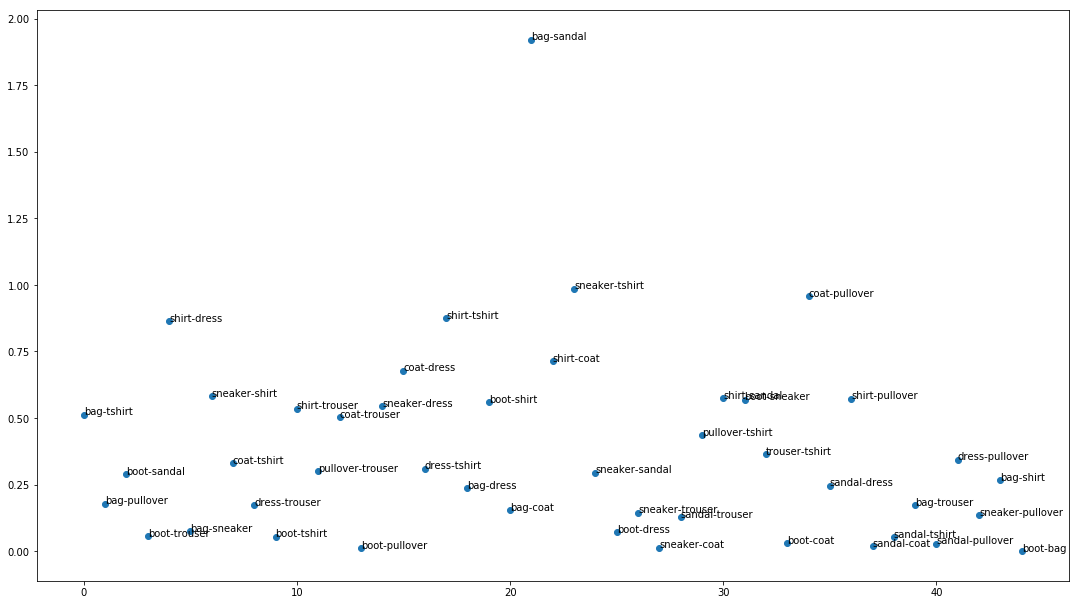

In [82]:
y = range(45)
z = pd_results.test_error_cda/pd_results.test_error_bnch
fig, ax = plt.subplots()
class1 = pd_results.class_1_nm.values
class2 = pd_results.class_2_nm.values
labels = list(class1+'-'+class2)
ax.scatter(y, z)
fig.set_size_inches(18.5, 10.5)

for i, txt in enumerate(labels):
    ax.annotate(txt, (y[i],z[i]))